In [1]:
import numpy as np
import torch
from pydub import AudioSegment
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get file list
l = []
with open("data/trainingset.csv") as f:
    for line in f:
        l.append(line.strip().split(","))
langs = sorted(list(set([x for _, x in l])))

In [3]:
k = 1 # dummy to get a song and label
song_label = l[k][1]
song_label_np = np.zeros(len(langs))
song_label_np[langs.index(song_label)] = 1
song_fp = "data/train/" + l[k][0]
song = AudioSegment.from_mp3(song_fp)
print(song_fp, song_label, song_label_np)
song

data/train/00c65e13-39e6-4b71-89c3-e855c616bdfc.mp3 French [ 0.  1.  0.  0.  0.]


44100 440064 9.978775510204082
(1, 440064) (5,)


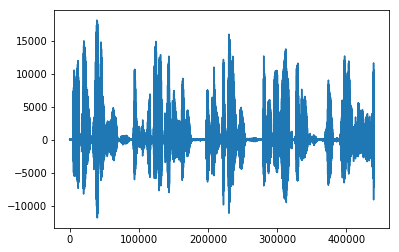

In [6]:
song.set_channels(1)
sr = song.frame_rate
data = np.array(song.get_array_of_samples())
print(sr, len(data), len(data) / sr)
data = data[None]
print(data.shape, song_label_np.shape)
plt.plot(range(data.shape[1]), data[0])

1024


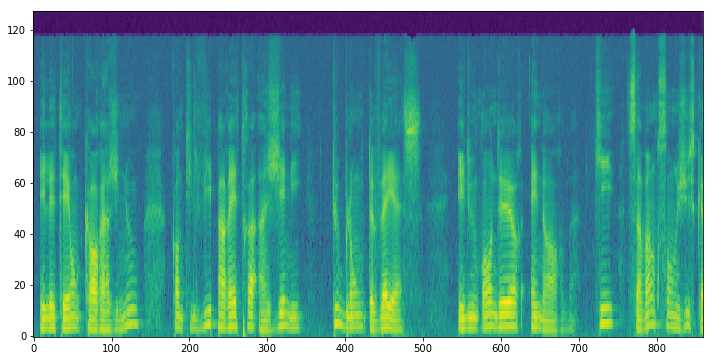

In [34]:
import librosa
sig, sample_rate = librosa.core.load(song_fp, sr=None)
wsize = 2 ** 10
print(wsize)
#wsize = 900
hsize = wsize // 2
IMG_SIZE = (12, 6)
S_mel = librosa.feature.melspectrogram(np.trim_zeros(sig), sr=sample_rate, n_fft=wsize, hop_length=hsize, n_mels=128)
fig1, ax1 = plt.subplots(figsize=IMG_SIZE)
ax1.imshow(np.log10(S_mel), interpolation='nearest',
                    aspect='auto', origin="lower")
plt.show()

In [20]:
# http://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module

from torch.autograd import Variable

N, D_in, H, D_out = 1, data.shape[1], 100, len(langs)

# Create random Tensors to hold inputs and outputs, and wrap them in Variables.
x = Variable(torch.from_numpy(data).float())
y = Variable(torch.from_numpy(song_label_np[None]).long(), requires_grad=False)
y = Variable(torch.LongTensor([langs.index(song_label)]), requires_grad=False)

print(y)

print(x.size())
print(y.size())

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.LogSoftmax(),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_old = np.inf
for t in range(15):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    loss_delta = loss_old - loss.data[0]
    """
    if loss_delta[0] < 0.0001:
        print("stopped at", t+1)
        break
    """ 
    loss_old = loss.data[0]
    if t % 3 == 0:
        print("Epoch:", t)
        print("Loss / delta:",loss.data, loss_delta)
        print("pred vs act:", y_pred, y)
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
print(model(x))


Variable containing:
 1
[torch.LongTensor of size 1]

torch.Size([1, 440064])
torch.Size([1])
Epoch: 0
Loss / delta: 
 1016.8470
[torch.FloatTensor of size 1]
 inf
pred vs act: Variable containing:
  -33.9891 -1016.8470     0.0000  -405.9078  -288.5204
[torch.FloatTensor of size 1x5]
 Variable containing:
 1
[torch.LongTensor of size 1]

Epoch: 3
Loss / delta: 
 0
[torch.FloatTensor of size 1]
 0.0
pred vs act: Variable containing:
-2.2932e+07  0.0000e+00 -5.4059e+07 -2.6355e+07 -2.1513e+07
[torch.FloatTensor of size 1x5]
 Variable containing:
 1
[torch.LongTensor of size 1]

Epoch: 6
Loss / delta: 
 0
[torch.FloatTensor of size 1]
 0.0
pred vs act: Variable containing:
-2.2932e+07  0.0000e+00 -5.4059e+07 -2.6355e+07 -2.1513e+07
[torch.FloatTensor of size 1x5]
 Variable containing:
 1
[torch.LongTensor of size 1]

Epoch: 9
Loss / delta: 
 0
[torch.FloatTensor of size 1]
 0.0
pred vs act: Variable containing:
-2.2932e+07  0.0000e+00 -5.4059e+07 -2.6355e+07 -2.1513e+07
[torch.FloatTensor